In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.model_selection import GroupKFold, GridSearchCV, RandomizedSearchCV

sns.set()
plt.style.use('classic')

# Features selection on Iris
See [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

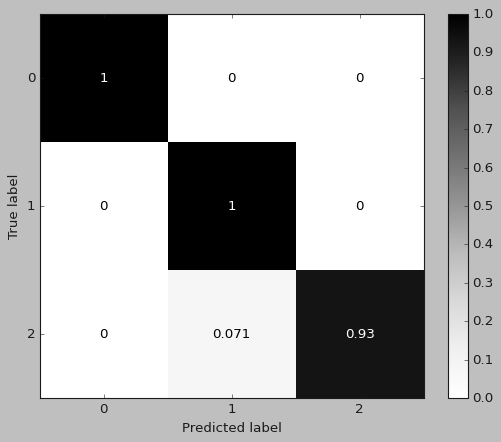

In [2]:
from sklearn.datasets import load_iris
dataset = load_iris()
X = dataset.data
y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

pipeline = Pipeline([
    ('scaling', StandardScaler(with_mean=False)),
    ('feature_selection', SequentialFeatureSelector(SVC(), n_features_to_select=3)),
    ('classification', KNeighborsClassifier(n_neighbors=3))])
pipeline.fit(X_train, y_train)
fig, ax = plt.subplots(1, 1)
plot_confusion_matrix(pipeline, 
                      X_test,
                      y_test, 
                      ax=ax,
                      cmap="Greys", 
                      normalize='true');

# Colorectal cancer classification (CRC)

## Glance at features correlation
[Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) implies that one or more of the features in your dataset are useless to the model. Thus you get all the problems associated with more features (i.e. [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)), but none of the benefits (e.g. making the classes easier separable).

Moreover, as discussed in Lab1, before eliminating features in a feature selection scenario, we would like to transform the complete feature space such that the underlying uncorrelated components are obtained.

## Load features

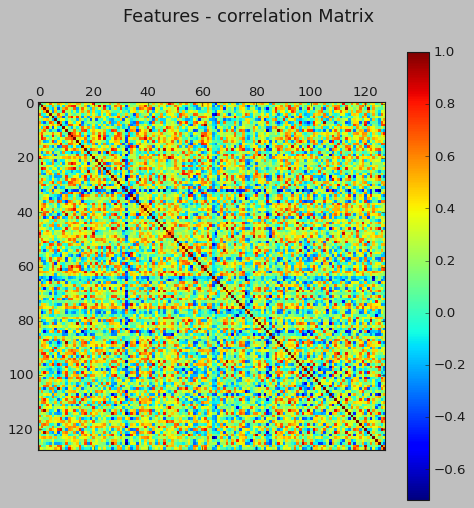

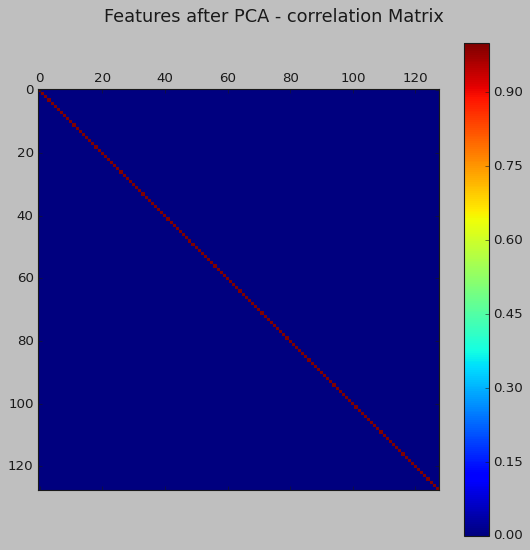

In [3]:
features_A_df = pd.read_csv("../data/features_A_df.csv", index_col="Image id")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
matrix = ax.matshow(features_A_df.select_dtypes(['number']).corr())
fig.colorbar(matrix, orientation='vertical')
fig.suptitle('Features - correlation Matrix', fontsize=16)

# Apply PCA
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
pipeline = Pipeline([('scaling', StandardScaler(with_mean=True)),
                     ('pca', PCA())])
X_df = pd.DataFrame(pipeline.fit_transform(features_A_df))
matrix = ax.matshow(X_df.select_dtypes(['number']).corr())
fig.colorbar(matrix, orientation='vertical')
fig.suptitle('Features after PCA - correlation Matrix', fontsize=16)
plt.tight_layout()

## Load dataset

In [4]:
dataset = pd.read_csv("../data/crc.csv")
dataset

,Patient,Label_3_classes,Path,Label_2_classes,Label_3_classes_numerical,Label_2_classes_numerical
0,P-2,AC,../data/crc/Annotation_0/AC/0.png,Not-H,0,1
1,P-2,AC,../data/crc/Annotation_0/AC/405.png,Not-H,0,1
2,P-2,AC,../data/crc/Annotation_0/AC/404.png,Not-H,0,1
3,P-2,AC,../data/crc/Annotation_0/AC/403.png,Not-H,0,1
4,P-2,AC,../data/crc/Annotation_0/AC/402.png,Not-H,0,1
...,...,...,...,...,...,...
13495,P-55,H,../data/crc/Annotation_30/H/243.png,H,2,0
13496,P-55,H,../data/crc/Annotation_30/H/242.png,H,2,0
13497,P-55,H,../data/crc/Annotation_30/H/241.png,H,2,0
13498,P-55,H,../data/crc/Annotation_30/H/253.png,H,2,0


## Putting all togheter first case study: 2 and 3 labels

In [5]:
# Comment/uncomment the following label_tag to change the classification mode
label_tag = 'Label_2_classes_numerical'  # Binary classification
# label_tag = 'Label_3_classes_numerical'  # Ternary classification
X = features_A_df
y = dataset[label_tag]

Firstly, split the dataset between train and test, based on Patient: <u>patients must be different between train and test</u>.
See [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Train fold will be used for grid parameter search in a GroupKFold fashion (See [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html)). <u>Again the grouping variable will be Patient</u>.

Test fold will furnish the final evaluation on never seen patients.

In [6]:
# Get all patients (unique only)
patients = dataset["Patient"].unique()

# Split patients into random train and test subsets
patients_train, patients_test = train_test_split(patients, test_size=0.3, random_state=0)

# Get training sets
X_train = X[dataset["Patient"].isin(patients_train)]
y_train = y[dataset["Patient"].isin(patients_train)]

# Get test sets
X_test = X[dataset["Patient"].isin(patients_test)]
y_test = y[dataset["Patient"].isin(patients_test)]

# Get training groups for later usage in GridSearchCV
groups_train = dataset["Patient"][dataset["Patient"].isin(patients_train)]

Define a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) with the following steps:
1. StandardScaler (with_mean=True)
2. PCA

[Here an example of pipelining](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html)

Implement an exhaustive [grid search](https://scikit-learn.org/stable/modules/grid_search.html) on the `train` fold for the following [supervised classifiers](https://scikit-learn.org/stable/supervised_learning.html):
* KNeighborsClassifier
* GaussianNB (is a Naive Bayes)
* SVM
* Random forest

Tailor the parameters to avoid too long computation. Evantually consider [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)

Evaluate performances of the best estimator on the `test` fold via [ROC curves](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html) for 2 classes fashion and [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix) for 3 classess.

In [7]:
# Define classifiers
classifiers = {
    "KNeighborsClassifier": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(),
    "RandomForestClassifier": RandomForestClassifier()
}

# Define pipelines
pipelines = {
    name: Pipeline([("StandardScaler", StandardScaler(with_mean=True)),
                    ("PCA", PCA()), (name, classifier)])
    for name, classifier in classifiers.items()
}

# Define GridSearchCV parameters
parameters = {
    # Values higher than 16 for the PCA allow to get >= 95% of the explained variance
    "KNeighborsClassifier": {
        "PCA__n_components": [16, 32, 48, 64],
        "KNeighborsClassifier__n_neighbors": [5, 25, 75, 100]
    },
    "GaussianNB": {
        "PCA__n_components": [16, 32, 48, 64],
        "GaussianNB__var_smoothing": [1e-08, 1e-9, 1e-10]
    },
    "SVC": {
        "PCA__n_components": [64],
        "SVC__C": [1, 10, 100, 1000],
        "SVC__gamma": [1e-3, 1e-4],
        "SVC__kernel": ["rbf"]
    },
    "RandomForestClassifier": {
        "PCA__n_components": [64],
        "RandomForestClassifier__max_features": ["log2"]
    }
}

In [8]:
# Define the number of splits
n_splits = 5

# Perform K-fold cross-validation
group_kfold = GroupKFold(n_splits=n_splits)

best_estimators = {}
# For each pipeline
for name, pipeline in pipelines.items():
    # Perform an exhaustive search over specified parameter values for an estimator
    search = GridSearchCV(estimator=pipeline,
                          param_grid=parameters[name],
                          cv=group_kfold,
                          verbose=3,
                          n_jobs=-1)
    # Run fit
    search.fit(X_train, y_train, groups=groups_train)
    # Store the estimator which gave highest score
    best_estimators[name] = search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


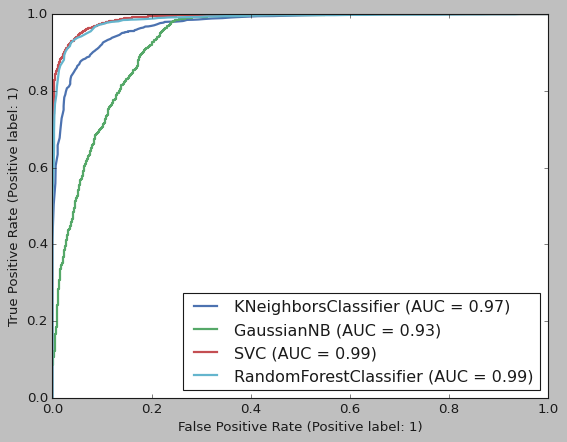

In [9]:
# If classification is binary
if label_tag == "Label_2_classes_numerical":
    fig, ax = plt.subplots(1, 1)
    # For each best estimator
    for name, best_estimator in best_estimators.items():
        # Plot the ROC curve
        plot_roc_curve(best_estimator, X_test, y_test, name=name, ax=ax, lw=2)

# Else, if classification is ternary
elif label_tag == "Label_3_classes_numerical":
    sns.set(style="ticks")
    # For each best estimator
    for name, best_estimator in best_estimators.items():
        fig, ax = plt.subplots()
        ax.set_title(name)
        # Plot the confusion matrix
        plot_confusion_matrix(best_estimator,
                              X_test,
                              y_test,
                              ax=ax,
                              normalize="true",
                              cmap="plasma")

# Else, the case cannot be handled
else:
    print("This label cannot be plotted.")